# Fake News Detection

## Milestone 2 
Name : Alexander Greateine Tanaku

Class: FTDS - 014

## Problem Statement
Make a deep learning model of RNN for Fake News Classifier (NLP).

## Import Library

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import nltk
import tensorflow as tf
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

## Loading Data

In [8]:
# Read CSV files

df = pd.read_csv('train.csv')
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


From the Dataset, Author of the news does not matter, someone can write fake and real news and the pattern will confuse computer, so I will only use Title and text as the corpus and label as the target.

### Dataset Description

1. ID : UniqueID for each news
2. Title : Title of the news
3. author : Author of of the news article
4. Text : The news text
5. label : 0 (Reliable), 1(Not Reliable)

## EDA 

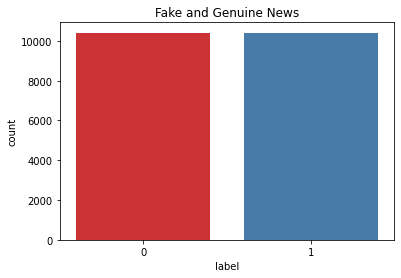

In [9]:
## Making a plot to see the target
sns.countplot(data=df, palette='Set1', x='label')
plt.title("Fake and Genuine News")
plt.show()

There are almost the same amount of fake news and reliable news in this data

In [10]:
df.author.unique().shape

(4202,)

There are 4202 author writing all these news

In [11]:
df.title.unique().shape

(19804,)

Although there are 20800 Title, the unique value of the title is only 19804, meaning that there are duplicates amongst these title

In [12]:
df[df.duplicated('title')]

,id,title,author,text,label
120,120,NaN,Anonymous,"Same people all the time , i dont know how you...",1
124,124,NaN,SeekSearchDestory,"You know, outside of any morality arguments, i...",1
140,140,NaN,Anonymous,There is a lot more than meets the eye to this...,1
196,196,NaN,Raffie,They got the heater turned up on high.,1
223,223,NaN,PhilSilversGhost,If I were one of those Guardsmen and the Spets...,1
...,...,...,...,...,...
20767,20767,Former Ambassador Andrew Young Calls for End t...,Activist Post,By Brandon Turbeville Anti-fluoridation activi...,1
20771,20771,NaN,Letsbereal,DYN's Statement on Last Week's Botnet Attack h...,1
20772,20772,NaN,beersession,Kinda reminds me of when Carter gave away the ...,1
20782,20782,The Fix Is In: NBC Affiliate Accidentally Post...,The Doc,Home » Headlines » World News » The Fix Is In:...,1


It seems that the duplicate title is a missing value although some of it is not a missing value. it will cause problem later in making neural networks if we include the missing value in the model, so I need to clean this data first. Handling the missing values is also important for EDA to make wordcloud.

## Missing Value Handling for EDA

In [13]:
# Checking missing values in Dataset
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [14]:
# Removing the missing values
df.dropna(axis=0, how='any',inplace=True)

df['raw_text_length'] = df['text'].apply(lambda x: len(x))

## Removing Hidden Missing Values

In [15]:
# Finding text with empty value
a = df[
    (df["text"] == ' ') |
    (df["text"] == '  ') 
].index

In [16]:
df.drop(a, inplace = True)
df.reset_index(drop = True, inplace = True)

I decide to drop all the data that is missing because for unstructured data, it is kinda hard to replace the value. The type of missing value is Missing Completely at Random because there are no pattern of missing values.

### Distribution for Fake News and Real News

In [17]:
# Making real and fake dataset
df_fake = df[df.label == 1]
df_real = df[df.label == 0]

In [18]:
# Making a function to see plot distribution
def plot_dist(df, col, k):
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    
    # histogram
    sns.histplot(df[col],ax = axes[0], kde=True,line_kws={'linewidth': 3},color = 'k', bins = k)
    axes[0].set_title(f"Histogram '{col}'")
    axes[0].axvline(df[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axes[0].axvline(df[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axes[0].legend()
    
    # boxplot
    sns.boxplot(y=df[col], ax =  axes[1])
    axes[1].set_title(f"Boxplot '{col}'")
    
    plt.show()
    
    # skewness
    print(df[col].name + ' Kurtosis: ' + str(df[col].kurt()))
    print(df[col].name + ' Skewness: ' + str(df[col].skew()))
    if -0.5 <= df[col].skew() <= 0.5:
        print("Columns '{}' normal distribution".format(col))
    elif df[col].skew() > 0.5:
        print("Columns '{}' right skewed".format(col))
    elif df[col].skew() < -0.5:
        print("Columns '{}' left skewed".format(col))
    print(f'Average of {col} is : ', df[col].mean())
    print(f'Median of {col} is : ', df[col].median())

## Fake News

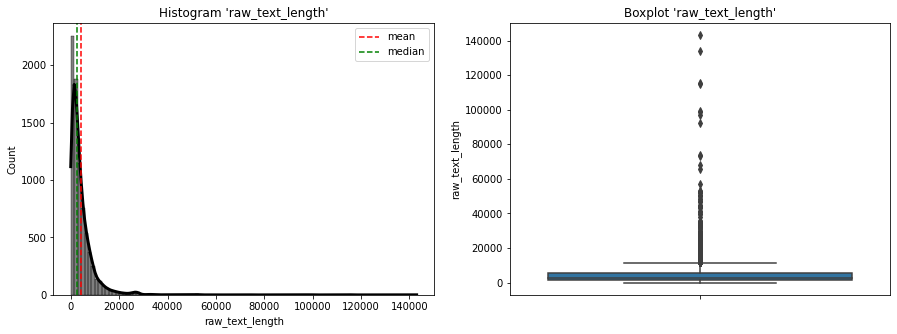

raw_text_length Kurtosis: 116.8629515576826
raw_text_length Skewness: 7.969971608497161
Columns 'raw_text_length' right skewed
Average of raw_text_length is :  4318.469112215004
Median of raw_text_length is :  2664.0


In [19]:
plot_dist(df_fake, 'raw_text_length', 100)

## Real News

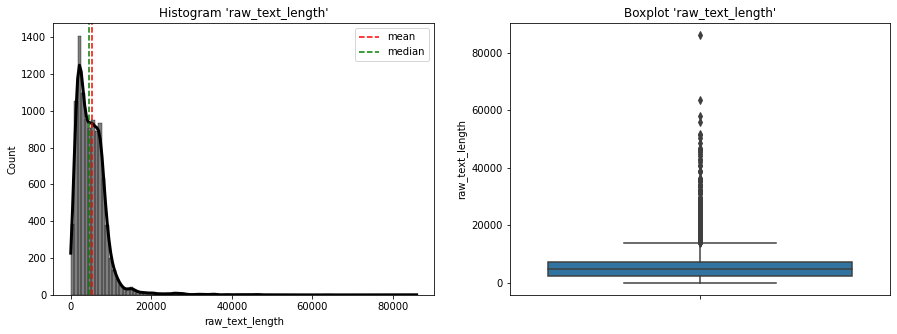

raw_text_length Kurtosis: 40.34597327926272
raw_text_length Skewness: 4.352352585466044
Columns 'raw_text_length' right skewed
Average of raw_text_length is :  5199.010713251617
Median of raw_text_length is :  4589.0


In [20]:
plot_dist(df_real, 'raw_text_length', 100)

## Insight
1. The average raw text length of Fake news is lower than real news
2. There is a fake news with a very lengthy text compared to real news
3. The median of fake news is only 2636, this median represent fake news better than the average because the data have an extreme outlier and that is also lower than real news.
4. In general, most of the news length is about 4000 - 5000 characters.

## Word Cloud

In [23]:
# Separating fake and real text for word cloud, I only use title for the word cloud
text_fake =  " ".join(title for title in df_fake.title)
text_real = " ".join(title for title in df_real.title)
stopwords = set(stopwords.words('english'))

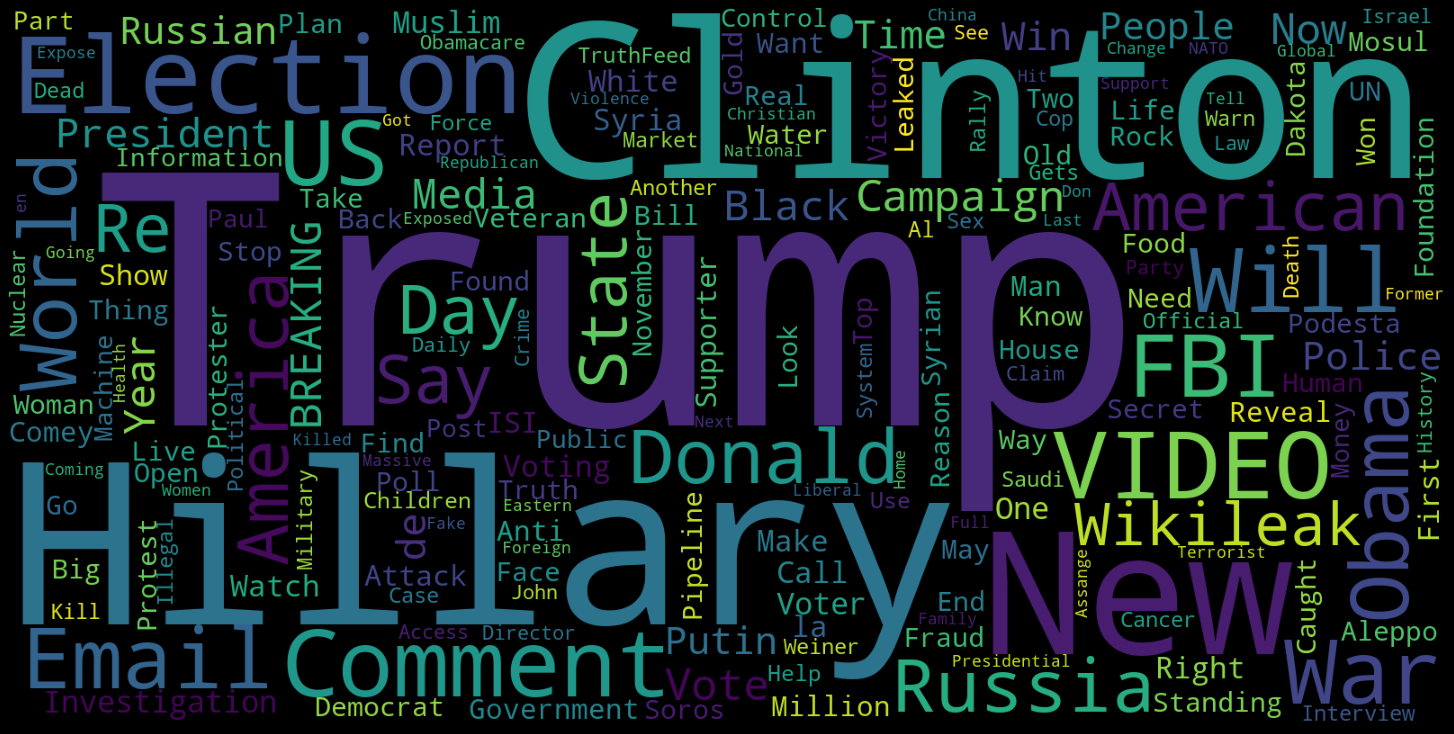

In [24]:
# Read the Text
wordcloud = WordCloud(width=1600, 
                      height=800,
                      collocations=False,
                      min_word_length=2).generate(text_fake)
# Open a plot of the generated image.

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

This is the word cloud for the fake news, the biggest word from the fake news is Trump and Hillary, although the data doesn't give any information about the date of when this news is published, we can see that it is probably that this data is taken near the president election event.

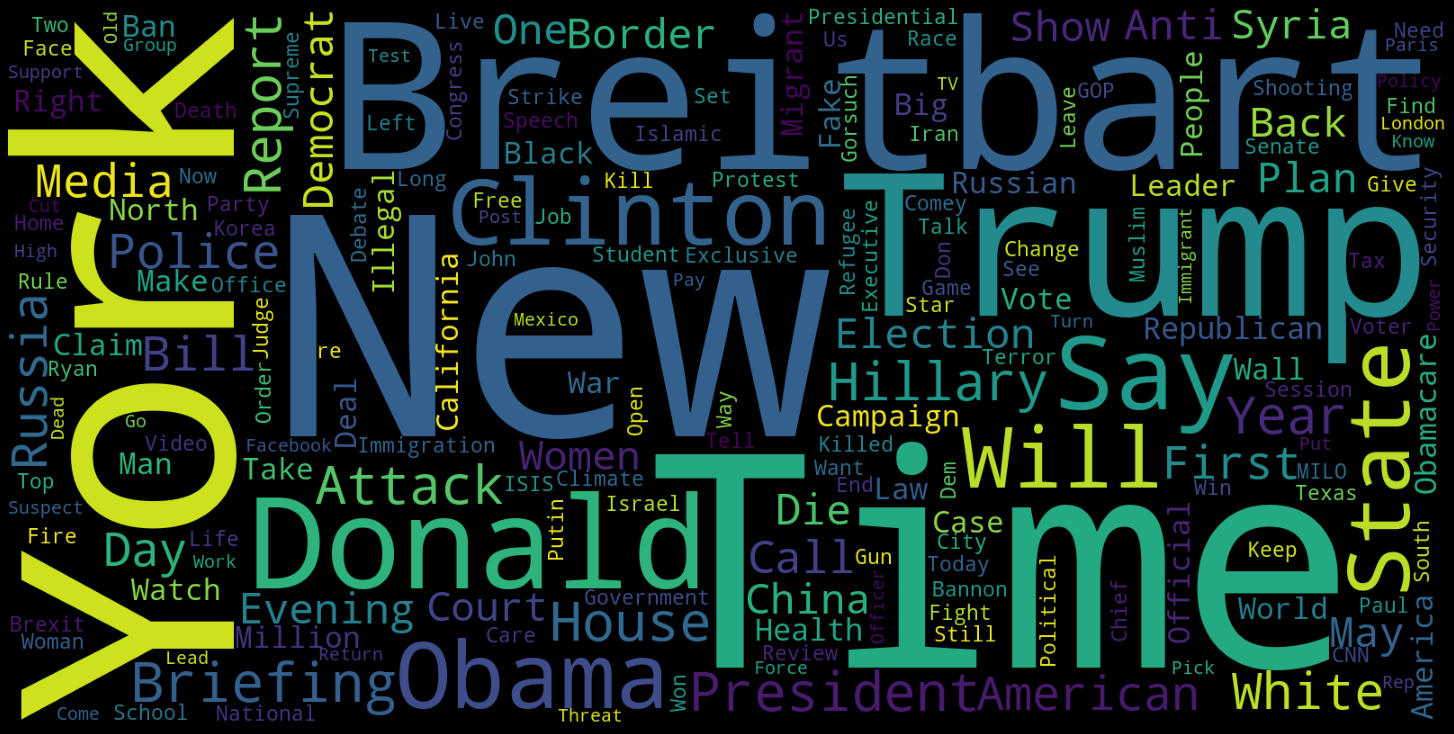

In [25]:
# Read the whole text.
wordcloud = WordCloud(width=1600, 
                      height=800,
                      collocations=False,
                      min_word_length=2).generate(text_real)
# Open a plot of the generated image.

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

There are some interesting things that we can see from the reliable news, the word New York and Time is the most word that comes out in the real news. Maybe because the publisher New York Times is the most publisher that publish real news. and again we still can see Trump name same like before.

It seems that fake News have longer text than real news, lets see the central Tendency of it

## Data Cleaning and Preprocessing

In [26]:
# preparing an empty array to be filled with combined dataset
combined = []

for idx in range(len(df)):
    res = str(df.title[idx])+ "-" + df.text[idx] 
    combined.append(res)

In [27]:
df['combine'] = combined

Combining text and title as the feature for my model. I don't put author as the feature because I think same author can make both fake and real news so I will just focus on the content here.

In [28]:
# Defining Stemmer
stemmer=SnowballStemmer(language = 'english')

Lemmatization and Stemming are the foundation of derived (inflected) words, the only difference between lemma and stem is that lemma is an actual word whereas, the stem may not be an actual language word. However, Lemmatization is computationally expensive because it look to the table a lot of the time compared to stemmer. Here I use PorterStemmer because the error rate is the lowest compared to the other stemmer.

In [29]:
print("rocky :", stemmer.stem("rocky"))
print("eyes :", stemmer.stem("eyes"))

rocky : rocki
eyes : eye


Here we can see that stemmer stem the word into it's root meaning but as a result, the output is not as accurate. for example the word rocky should be changed to rock, but instead it changed into rocki, this is because stemmer does not have a table of their true meaning like lemmatizer, but Stemmer is faster than lemmatizer, hence I will use stemmer. I decide to use Snowball Stemmer because Snowball stemmer fix what have been an error in PorterStemmer and it is an aggresive stemmer, many said that snowball stemmer is like porterstemmer 2.

In [30]:
# Pre processing function
def clean(text):
    # text="".join([char for char in text if char not in string.punctuation])
    text=text.lower() # Lowering the case
    text = re.sub("[^A-Za-z\s']"," ", text) # Choosing only words
    text = text.strip() #Menghilangkan whitespace
    text = word_tokenize(text) # Change to Token
    text=[stemmer.stem(word) for word in text if word not in set(stopwords.words("english"))] # Stemming to find the root meaning
    text=" ".join(text) ## Joining them back into a document
    return text

In [33]:
df['clean']=df['combine'].apply(clean) # Applying the Function to the dataframe

In [35]:
# Putting the cleaned data into a corpus variable
corpus = np.array(df['clean'])

# Deep Learning Work Area

## Inferencing

In [41]:
# Inferencing data
data_inf = df.sample(10, random_state = 17)
data_train_test = df.drop(data_inf.index)

# Resetting the index
data_train_test.reset_index(inplace = True, drop = True)
data_inf.reset_index(drop = True, inplace = True)

## Train Test Split

In [42]:
# Splitting the dataset into train and testing

X_train, X_test, y_train, y_test = train_test_split(data_train_test.clean, 
                                                    data_train_test.label,test_size=0.25, 
                                                    random_state=13,
                                                    stratify=data_train_test.label)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.90,random_state = 17)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)
print('Val Size : ', X_val.shape)

Train Size :  (12285,)
Test Size  :  (4551,)
Val Size :  (1366,)


## Feature Engineering - Tokenizer and Padding

In [43]:
# Mencari Jumlah Vocab dan Panjang Token dalam Satu DOcument


tokenizer = Tokenizer(oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)
voc_max = len(tokenizer.word_index) + 1 # see how many voc size we have, the plus 1 is for padding
sent_length = max([len(i.split(" ")) for i in X_train])
print('vocabulary size: {}'.format(voc_max))
print('max sentence length: {}'.format(sent_length))

vocabulary size: 83915
max sentence length: 10527


### Tokenizer Explanation
1. replace unknow vocab with out of vocab
2. tokenize the train data
3. find how many unique vocabulary that I have
4. find the maximum sentence length

In [44]:
# padding all feature dataset
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=sent_length)
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=sent_length)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=sent_length)

print('Shape of train: {}'.format(X_train.shape))
print('Shape of label of train: {}'.format(y_train.shape))
print('Shape of validation: {}'.format(X_val.shape))
print('Shape of label of val: {}'.format(y_val.shape))

Shape of train: (12285, 10527)
Shape of label of train: (12285,)
Shape of validation: (1366, 10527)
Shape of label of val: (1366,)


### Padding Explanation
1. Tokenizer.text_to_sequence change the text into a one hot encoding or to a sequence.
2. Pad sequence is for padding the sequence so that all of it have the same shape

## Tensorflow Input Pipeline

In [45]:
# Make tensorflow input Pipeline for faster processing
tf_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = tf_train.shuffle(buffer_size=128).batch(64)

tf_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = tf_test.shuffle(buffer_size=128).batch(64)

tf_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = tf_val.batch(64)

In [46]:
# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
tf_train = tf_train.cache().prefetch(buffer_size=AUTOTUNE)

## LSTM Model without Tuning

In [69]:
#Creating the lstm model

embedding_vector_features= 40
model=Sequential()
model.add(Embedding(voc_max,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100)) #Adding 100 lstm neurons in the layer
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 10527, 40)         3356600   
                                                                 
 lstm_8 (LSTM)               (None, 100)               56400     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,413,101
Trainable params: 3,413,101
Non-trainable params: 0
_________________________________________________________________
None


## Model Explanation
1. the first layer is for embedding the feature into a higher dimension, here I choose 40 as the dimension, those embedded vector will be the input
2. I add LSTM neuron for the second layer to find the pattern of data
3. For the output model, I will use Sigmoid as my activation function because the target is only 2
4. I use adam as my optimizer because adam is faster than SGD since we are having a lot of parameters here and adam is just as good.
5. The loss function is binary crossentropy because we only have 2 target and my metrics will be accuracy to determine how accurate my model will be

In [70]:
# Fitting with 10 epochs and 64 batch size
history1 = model.fit(train_dataset,validation_data=(val_dataset),epochs=10,batch_size=64)

Epoch 1/10
192/192 [==============================] - 93s 473ms/step - loss: 0.4004 - accuracy: 0.8269 - val_loss: 0.3057 - val_accuracy: 0.8543
Epoch 2/10
192/192 [==============================] - 87s 455ms/step - loss: 0.1137 - accuracy: 0.9588 - val_loss: 0.1914 - val_accuracy: 0.9297
Epoch 3/10
192/192 [==============================] - 90s 470ms/step - loss: 0.0439 - accuracy: 0.9867 - val_loss: 0.2710 - val_accuracy: 0.9100
Epoch 4/10
192/192 [==============================] - 87s 452ms/step - loss: 0.0189 - accuracy: 0.9948 - val_loss: 0.2633 - val_accuracy: 0.9319
Epoch 5/10
192/192 [==============================] - 87s 453ms/step - loss: 0.0131 - accuracy: 0.9961 - val_loss: 0.2922 - val_accuracy: 0.9165
Epoch 6/10
192/192 [==============================] - 87s 451ms/step - loss: 0.0103 - accuracy: 0.9972 - val_loss: 0.3057 - val_accuracy: 0.9224
Epoch 7/10
192/192 [==============================] - 87s 452ms/step - loss: 0.0082 - accuracy: 0.9971 - val_loss: 0.3322 - val_ac

## Model Evaluation

In [71]:
result = model.evaluate(test_dataset)

72/72 [==============================] - 12s 167ms/step - loss: 0.3306 - accuracy: 0.9275


In [72]:
y_pred = model.predict(X_test)

In [73]:
# Checking the result of prediction
score = []

for y in y_pred:
    if y<0.499:
        y = 0
    else:
        y = 1
    score.append(y)

# y_pred

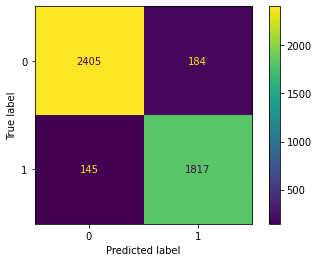

accuracy score of the test dataset 0.927708196000879


In [74]:
cm = confusion_matrix(y_test, score)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

print('accuracy score of the test dataset', accuracy_score(y_test,score))

Here we have a pretty good result, there are 2405 correct prediction of class 0 and 1817 correct prediction of class 1, however our model still detect 145 model as real news although it is fake.

---



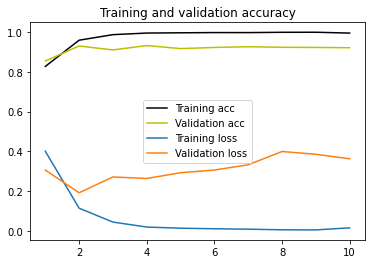

In [77]:
# Visualize accuracy and loss for train and validation data

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, 11)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'k', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.legend()

From the result, it is shown that this model is quite over fitting, the accuracy for train is too high compared to the validation accuracy and the loss is so low compared to the validation loss.

## Model Improvement

In [79]:
#Creating the lstm model

sgd = SGD(learning_rate=0.07, momentum = 0.9)

embedding_vector_features= 40
tuned_model=Sequential()
tuned_model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
tuned_model.add(Dropout(0.2))
tuned_model.add(LSTM(100)) #Adding 100 lstm neurons in the layer
tuned_model.add(Dropout(0.2))
tuned_model.add(Dense(1,activation='sigmoid'))

#Compiling the model
tuned_model.compile(loss='binary_crossentropy',optimizer= sgd, metrics=['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 10527, 40)         3356600   
                                                                 
 lstm_8 (LSTM)               (None, 100)               56400     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,413,101
Trainable params: 3,413,101
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
history2 = tuned_model.fit(train_dataset,validation_data=(val_dataset),epochs=10,batch_size=64)

Epoch 1/10
192/192 [==============================] - 90s 462ms/step - loss: 0.6568 - accuracy: 0.5970 - val_loss: 0.6114 - val_accuracy: 0.6332
Epoch 2/10
192/192 [==============================] - 88s 458ms/step - loss: 0.4422 - accuracy: 0.7877 - val_loss: 0.6041 - val_accuracy: 0.6999
Epoch 3/10
192/192 [==============================] - 88s 460ms/step - loss: 0.4227 - accuracy: 0.8015 - val_loss: 0.5961 - val_accuracy: 0.7430
Epoch 4/10
192/192 [==============================] - 88s 457ms/step - loss: 0.2768 - accuracy: 0.8875 - val_loss: 0.2990 - val_accuracy: 0.8785
Epoch 5/10
192/192 [==============================] - 88s 458ms/step - loss: 0.2430 - accuracy: 0.9031 - val_loss: 0.3271 - val_accuracy: 0.8712
Epoch 6/10
192/192 [==============================] - 88s 458ms/step - loss: 0.3665 - accuracy: 0.8374 - val_loss: 0.5075 - val_accuracy: 0.8397
Epoch 7/10
192/192 [==============================] - 90s 466ms/step - loss: 0.2566 - accuracy: 0.8973 - val_loss: 0.4618 - val_ac

## Model Improvement - Evaluation

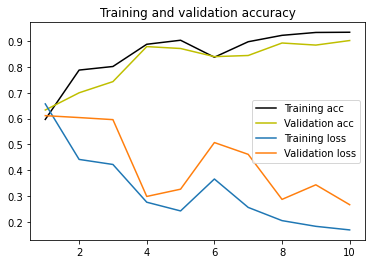

In [81]:
# Visualize accuracy and loss for train and validation data

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, 11)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'k', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.legend()

For the Tuned Model, I decide to use Stochastic Gradient Descent and as a result, the loss is descending like it should. I use SGD with momentum to quickly descend to the point of lowest loss function. SGD is better than adam in term of generalization according to a research paper. but adam is better in converging quickly. after optimizing the model we have lower loss and no overfitting. I also decide to put the learning rate to 0.07 because lower learning rate meaning that the model descent slower.

In [82]:
result2 = tuned_model.evaluate(test_dataset)

72/72 [==============================] - 12s 169ms/step - loss: 0.2380 - accuracy: 0.9132


The accuracy may be a little bit lower, but the loss is also lower than pre tuned model. this model predict better for a larger dataset because of low loss compared to the tuned model. overall the tuning process is a success.

## Model Inference Testing

In [84]:
data_inf

,id,title,author,text,label,raw_text_length,combine,clean
0,2806,"U.S. Presses for Truce in Syria, With Its Larg...",Mark Landler and Mark Mazzetti,"HANGZHOU, China — The image of a Syrian ...",0,8296,"U.S. Presses for Truce in Syria, With Its Larg...",u press truce syria larger polici paus new yor...
1,11589,AFT President Weingarten: Trump’s Budget ’Take...,Dr. Susan Berry,The president of the American Federation of Te...,0,4796,AFT President Weingarten: Trump’s Budget ’Take...,aft presid weingarten trump budget take meat c...
2,8891,"With Flood of Urbanites, a Canadian Hippie Hav...",Dan Levin,"NELSON, British Columbia — Marijuana, Vietn...",0,6248,"With Flood of Urbanites, a Canadian Hippie Hav...",flood urbanit canadian hippi tri keep mellow n...
3,18883,"A ‘Stonehenge,’ and a Mystery, in the Amazon -...",Simon Romero,"CALÇOENE, Brazil — As the foreman for a cat...",0,6677,"A ‘Stonehenge,’ and a Mystery, in the Amazon -...",stoneheng mysteri amazon new york time cal oen...
4,253,Islamic State Supporting Former National Guard...,Jenna Leigh Richardson,Former National Guardsman turned Islamic State...,1,2786,Islamic State Supporting Former National Guard...,islam state support former nation guardsman pl...
5,7535,Trump’s New Defense Strategy On ‘Access Hollyw...,Sean Colarossi,"Thu, Oct 27th, 2016 at 9:02 pm It's amazing ho...",1,1976,Trump’s New Defense Strategy On ‘Access Hollyw...,trump new defens strategi access hollywood tap...
6,17662,Germany: Migrant Bursts Into Wedding Screaming...,Andrew Anglin,Daily Mail : \nA newlywed couple have claimed ...,1,1244,Germany: Migrant Bursts Into Wedding Screaming...,germani migrant burst wed scream allah akbar d...
7,4978,Melissa Gilbert Never Saw Congress in Her Futu...,Ana Marie Cox,"As a child, you played Laura Ingalls Wilder in...",0,3652,Melissa Gilbert Never Saw Congress in Her Futu...,melissa gilbert never saw congress futur new y...
8,8822,Nation’s Largest Offshore Wind Farm Will Be Bu...,Diane Cardwell,"UNIONDALE, N. Y. — Seeking to meet growing ...",0,4740,Nation’s Largest Offshore Wind Farm Will Be Bu...,nation largest offshor wind farm built long is...
9,2561,Wow!,Gillian,http://www.thepoliticalinsider.com/wikileaks-c...,1,1214,Wow!-http://www.thepoliticalinsider.com/wikile...,wow http www thepoliticalinsid com wikileak co...


In [86]:
X_inf = data_inf.text
y_inf = data_inf.label

In [88]:
data_inf['clean']=data_inf['text'].apply(clean)

In [93]:
## Padding and Tokenizer

X_inf = pad_sequences(tokenizer.texts_to_sequences(X_inf), maxlen=sent_length)

In [96]:
# Testing on inference data with Un tuned model
result3 = model.evaluate(X_inf, y_inf)

1/1 [==============================] - 1s 959ms/step - loss: 5.7094 - accuracy: 0.4000


In [98]:
# Testing on inference data with tuned model
result3 = tuned_model.evaluate(X_inf, y_inf)

1/1 [==============================] - 0s 336ms/step - loss: 1.5455 - accuracy: 0.6000


The result of our model on model inference is 0.6 accuracy for tuned model and 0.4 for pre tuned model. there are rooms for improvement for this model and the model does the job quite poorly on our inference dataset.

# Conclusion
1. Fake news usually have fewer words length than real news
2. NLP can automate the process of classifying news
3. SGD is better at generalzing while adam works faster
4. Data pre processing is crucial for nlp

## Improvement for next Model

1. Translate all document into 1 language
2. Deeply find missing values
3. Try more hidden layers
4. Try more hyperparameter tuning
5. Find a better dataset.